Submitted by: Sampriti Mahapatra, MDS202433

# SMS Spam Classification - Data Preparation

This notebook loads, preprocesses, splits, and saves the SMS spam dataset for model training.

## Imports and Setup

In [18]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Data

Load SMS spam data from tab-separated file.

In [ ]:
def load_data(file_path):
    # Read tab-separated file with proper encoding
    df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'], encoding='utf-8')
    
    print(f"Total samples: {len(df)}")
    print(f"\nClass distribution:")
    print(df['label'].value_counts())
    print(f"\nClass percentages:")
    print(df['label'].value_counts(normalize=True) * 100)
    
    # Check for missing values
    print(f"\nMissing values:")
    print(df.isnull().sum())
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates}")
    
    return df

## Exploratory Data Analysis

In [3]:
# Load the dataset
data_path = '/Users/sampriti/Downloads/cmi/AML 1/sms+spam+collection/SMSSpamCollection'
df = load_data(data_path)

Total samples: 5572

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class percentages:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

Missing values:
label      0
message    0
dtype: int64

Duplicate rows: 403


In [4]:
# Display first few rows
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Display sample messages from each class
print("Sample HAM messages:")
for i, msg in enumerate(df[df['label'] == 'ham']['message'].sample(3, random_state=RANDOM_STATE).values, 1):
    print(f"{i}. {msg}")
    print()

print("\nSample SPAM messages:")
for i, msg in enumerate(df[df['label'] == 'spam']['message'].sample(3, random_state=RANDOM_STATE).values, 1):
    print(f"{i}. {msg}")
    print()

Sample HAM messages:
1. If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.

2. I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.

3. Sorry that took so long, omw now


Sample SPAM messages:
1. Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804

2. This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate 

3. Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just £1.50 per wk 2 opt out send STOP 08452810071 16



In [6]:
# Calculate message statistics
df['message_length'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().str.len()

# Statistics by class
print("Message Length Statistics:")
print(df.groupby('label')['message_length'].describe())
print("\nWord Count Statistics:")
print(df.groupby('label')['word_count'].describe())

Message Length Statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

Word Count Statistics:
        count       mean        std  min   25%   50%   75%    max
label                                                            
ham    4825.0  14.310259  11.517945  1.0   7.0  11.0  19.0  171.0
spam    747.0  23.911647   5.780174  2.0  22.0  25.0  28.0   35.0


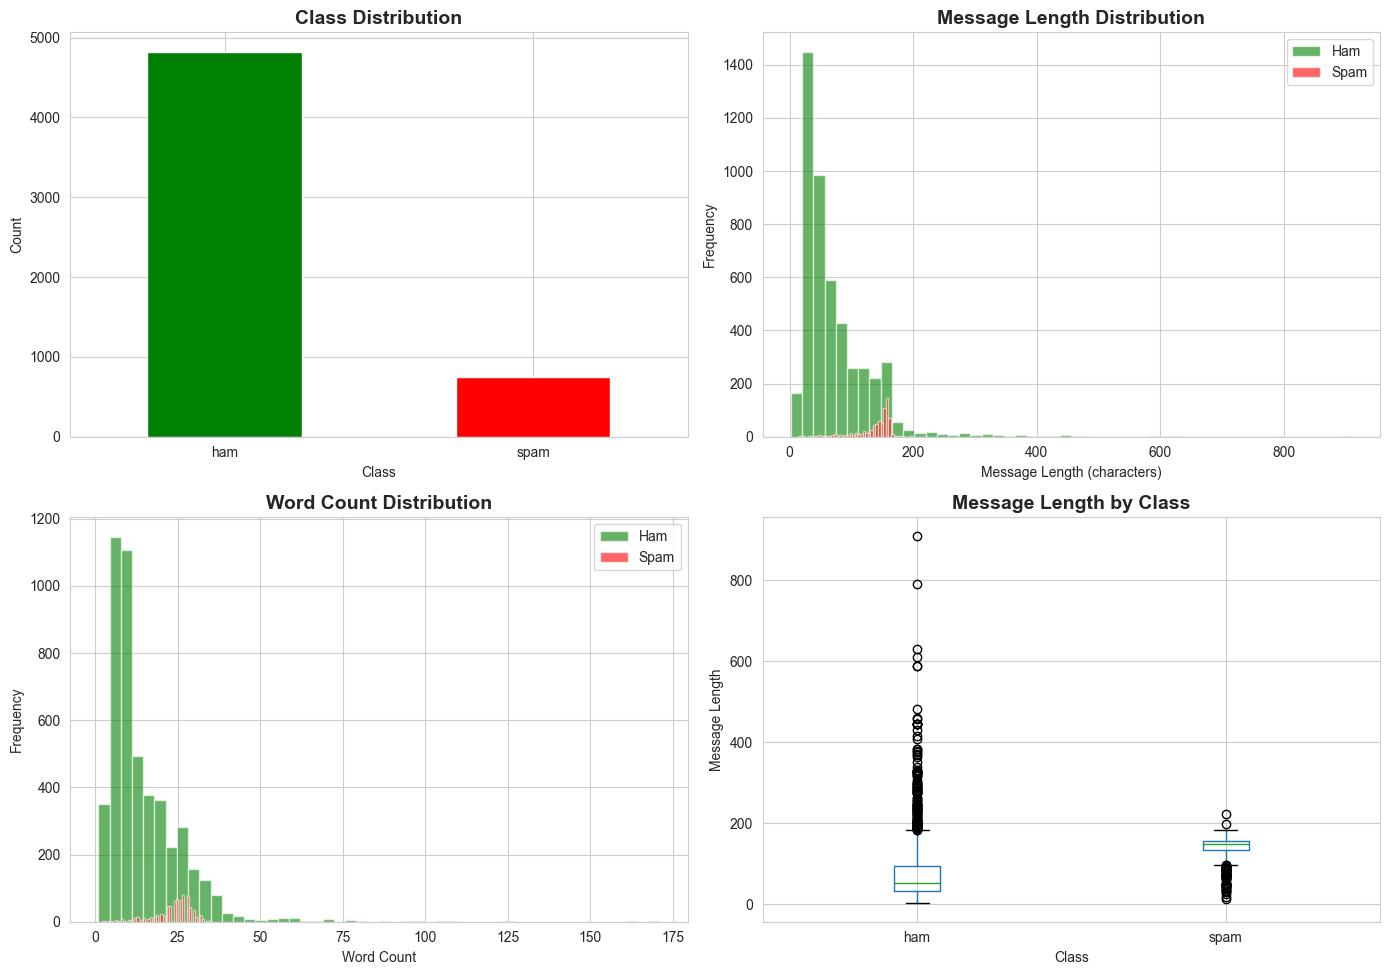

In [7]:
# Visualize class distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Class distribution
df['label'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
axes[0, 0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Class')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# Plot 2: Message length distribution
df[df['label'] == 'ham']['message_length'].hist(bins=50, alpha=0.6, label='Ham', ax=axes[0, 1], color='green')
df[df['label'] == 'spam']['message_length'].hist(bins=50, alpha=0.6, label='Spam', ax=axes[0, 1], color='red')
axes[0, 1].set_title('Message Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Message Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Plot 3: Word count distribution
df[df['label'] == 'ham']['word_count'].hist(bins=50, alpha=0.6, label='Ham', ax=axes[1, 0], color='green')
df[df['label'] == 'spam']['word_count'].hist(bins=50, alpha=0.6, label='Spam', ax=axes[1, 0], color='red')
axes[1, 0].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Plot 4: Box plot comparison
df.boxplot(column='message_length', by='label', ax=axes[1, 1])
axes[1, 1].set_title('Message Length by Class', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Message Length')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

## Preprocess Text

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace URLs with token
    text = re.sub(r'http\S+|www\S+|https\S+', 'URL', text, flags=re.MULTILINE)
    
    # Replace phone numbers with token (various formats)
    text = re.sub(r'\b\d{5,}\b', 'PHONE', text)  # 5+ consecutive digits
    text = re.sub(r'\+?\d[\d\s\-\(\)]{7,}\d', 'PHONE', text)  # Phone formats
    
    # Replace currency symbols with token
    text = re.sub(r'[£$€¥₹]', 'CURRENCY', text)
    
    # Replace numbers with token (but keep single digits for now)
    text = re.sub(r'\b\d{2,}\b', 'NUMBER', text)
    
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [9]:
# Test preprocessing function
test_messages = [
    "FREE! Win £1000 cash prize. Text WIN to 87121",
    "Hey, how are you doing today?",
    "Visit http://spam.com for amazing deals! Call 555-1234",
    "Ok lar... Joking wif u oni..."
]

print("Preprocessing Examples:")
for original in test_messages:
    cleaned = preprocess_text(original)
    print(f"Original: {original}")
    print(f"Cleaned:  {cleaned}")
    print()

Preprocessing Examples:
Original: FREE! Win £1000 cash prize. Text WIN to 87121
Cleaned:  free win 1000 cash prize text win to

Original: Hey, how are you doing today?
Cleaned:  hey how are you doing today

Original: Visit http://spam.com for amazing deals! Call 555-1234
Cleaned:  visit for amazing deals call

Original: Ok lar... Joking wif u oni...
Cleaned:  ok lar joking wif u oni



In [10]:
# Apply preprocessing to all messages
print("Preprocessing all messages...")
df['cleaned_message'] = df['message'].apply(preprocess_text)

# Verify no empty messages after cleaning
empty_count = (df['cleaned_message'].str.len() == 0).sum()
print(f"Empty messages after cleaning: {empty_count}")

# Display examples
print("\nCleaning Results (sample):")
df[['message', 'cleaned_message']].sample(5, random_state=RANDOM_STATE)

Preprocessing all messages...
Empty messages after cleaning: 3

Cleaning Results (sample):


,message,cleaned_message
3245,Squeeeeeze!! This is christmas hug.. If u lik ...,squeeeeeze this is christmas hug if u lik my f...
944,And also I've sorta blown him off a couple tim...,and also i ve sorta blown him off a couple tim...
1044,Mmm thats better now i got a roast down me! i...,mmm thats better now i got a roast down me i d...
2484,Mm have some kanji dont eat anything heavy ok,mm have some kanji dont eat anything heavy ok
812,So there's a ring that comes with the guys cos...,so there s a ring that comes with the guys cos...


## Split data into train/test/validation sets

In [ ]:
def split_data(df, train_size=0.70, val_size=0.15, test_size=0.15, random_state=42):
    # Verify proportions sum to 1
    assert abs(train_size + val_size + test_size - 1.0) < 0.001, "Split proportions must sum to 1"
    
    # First split: separate test set
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=df['label']
    )
    
    # Second split: separate train and validation
    val_proportion = val_size / (train_size + val_size)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_proportion,
        random_state=random_state,
        stratify=train_val_df['label']
    )
    
    # Display split statistics
    print("Data Split Summary:")
    print(f"Total samples: {len(df)}")
    print(f"\nTraining set:   {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
    print(f"Test set:       {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")
    
    # Verify stratification
    print("\nClass distribution in each split:")
    
    for split_name, split_df in [('Training', train_df), ('Validation', val_df), ('Test', test_df)]:
        spam_count = (split_df['label'] == 'spam').sum()
        ham_count = (split_df['label'] == 'ham').sum()
        spam_pct = spam_count / len(split_df) * 100
        print(f"{split_name:12s}: Ham={ham_count:4d} ({100-spam_pct:5.2f}%), Spam={spam_count:3d} ({spam_pct:5.2f}%)")
    
    # Verify no overlap
    train_indices = set(train_df.index)
    val_indices = set(val_df.index)
    test_indices = set(test_df.index)
    
    assert len(train_indices & val_indices) == 0, "Train and validation sets overlap"
    assert len(train_indices & test_indices) == 0, "Train and test sets overlap"
    assert len(val_indices & test_indices) == 0, "Validation and test sets overlap"
    print("No data leakage detected between splits")
    
    return train_df, val_df, test_df

In [20]:
# Split the data
train_df, val_df, test_df = split_data(
    df,
    train_size=0.70,
    val_size=0.15,
    test_size=0.15,
    random_state=RANDOM_STATE
)

Data Split Summary:
Total samples: 5572

Training set:   3900 samples (70.0%)
Validation set: 836 samples (15.0%)
Test set:       836 samples (15.0%)

Class distribution in each split:
Training    : Ham=3377 (86.59%), Spam=523 (13.41%)
Validation  : Ham= 724 (86.60%), Spam=112 (13.40%)
Test        : Ham= 724 (86.60%), Spam=112 (13.40%)
No data leakage detected between splits


In [13]:
# Filter out rows with empty cleaned_message
print("\nFiltering out empty cleaned messages...")
print(f"Before filtering:")
print(f"  Training: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

# Count empty messages in each split
train_empty = (train_df['cleaned_message'].str.len() == 0).sum()
val_empty = (val_df['cleaned_message'].str.len() == 0).sum()
test_empty = (test_df['cleaned_message'].str.len() == 0).sum()
print(f"\nEmpty messages to remove:")
print(f"  Training: {train_empty}")
print(f"  Validation: {val_empty}")
print(f"  Test: {test_empty}")

# Filter out empty messages
train_df = train_df[train_df['cleaned_message'].str.len() > 0].copy()
val_df = val_df[val_df['cleaned_message'].str.len() > 0].copy()
test_df = test_df[test_df['cleaned_message'].str.len() > 0].copy()

print(f"\nAfter filtering:")
print(f"  Training: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df)} samples")
print("\nEmpty messages removed successfully")


Filtering out empty cleaned messages...
Before filtering:
  Training: 3900 samples
  Validation: 836 samples
  Test: 836 samples

Empty messages to remove:
  Training: 2
  Validation: 0
  Test: 1

After filtering:
  Training: 3898 samples
  Validation: 836 samples
  Test: 835 samples
  Total: 5569 samples

Empty messages removed successfully


## Save splits as csv files

In [ ]:
def save_splits(train_df, val_df, test_df, output_dir='.'):
    import os
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define file paths
    train_path = os.path.join(output_dir, 'train.csv')
    val_path = os.path.join(output_dir, 'validation.csv')
    test_path = os.path.join(output_dir, 'test.csv')
    
    # Select columns to save (label, original message, cleaned message)
    columns_to_save = ['label', 'message', 'cleaned_message']
    
    # Save to CSV
    train_df[columns_to_save].to_csv(train_path, index=False)
    val_df[columns_to_save].to_csv(val_path, index=False)
    test_df[columns_to_save].to_csv(test_path, index=False)
    
    print("Files saved successfully:")
    print(f"Training set:   {train_path}")
    print(f"Validation set: {val_path}")
    print(f"Test set:       {test_path}")

In [22]:
# Save the splits
output_directory = '/Users/sampriti/Downloads/cmi/AML 1'
save_splits(train_df, val_df, test_df, output_dir=output_directory)

Files saved successfully:
Training set:   /Users/sampriti/Downloads/cmi/AML 1/train.csv
Validation set: /Users/sampriti/Downloads/cmi/AML 1/validation.csv
Test set:       /Users/sampriti/Downloads/cmi/AML 1/test.csv
